## MICCAI PLS Baseline

### Imports

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from imports import *

In [28]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [29]:
# overall imports
import importlib
import data

# data load
import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_shared_matrices,
    process_cv_splits,  
    expanded_inner_folds_combined_plus_indices
)

import models
import models.metrics
from models.metrics import *

## Specify connectome and transcriptome

Full brain HCP Enigma

In [30]:
HCP_enigma_structural_count, HCP_enigma_labels, HCP_enigma_lh_indices, HCP_enigma_rh_indices = load_connectome(measure='SC', omit_subcortical=False, include_labels=True, diag=0)
HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_coords = load_coords(parcellation='S100', omit_subcortical=False)
HCP_coords_left = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='left')
HCP_coords_right = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='right')
AHBAS100_transcriptome_PCA = load_transcriptome(parcellation='S100', omit_subcortical=False, run_PCA=True)
AHBAS100_transcriptome = load_transcriptome(parcellation='S100', omit_subcortical=False)

Number of components for 95% variance PCA: 34


Full brain HCP1200 and UKBB

In [35]:
hemisphere = 'left' 
PCA = True

HCP1200_structural_count, HCP1200_labels, HCP1200_lh_indices, HCP1200_rh_indices = load_connectome(measure='SC', parcellation='S400', omit_subcortical=False, include_labels=True)
HCP1200_functional_conn = load_connectome(measure='FC', parcellation='S400', omit_subcortical=False)
HCP1200_coords = load_coords(parcellation='S400', omit_subcortical=False)
AHBAS400_transcriptome = load_transcriptome(parcellation='S400', omit_subcortical=False, run_PCA=PCA)

# Find rows that are all NaN - there are 66 regions that are unsampled, and 9 cerebellar regions that are not assigned to hemispheres
nan_rows = np.isnan(AHBAS400_transcriptome).all(axis=1)
nan_row_indices = np.where(nan_rows)[0]
print(f"Original shape of AHBAS400_transcriptome: {AHBAS400_transcriptome.shape}")

# Get valid indices for left and right hemispheres by excluding NaN rows
valid_left_indices = [i for i in HCP1200_lh_indices if i not in nan_row_indices]
valid_right_indices = [i for i in HCP1200_rh_indices if i not in nan_row_indices]

if hemisphere == 'left':
    valid_indices = valid_left_indices
elif hemisphere == 'right':
    valid_indices = valid_right_indices
else: # Combine valid indices from both hemispheres
    valid_indices = valid_left_indices + valid_right_indices

# Subset transcriptome and connectomes to only include valid regions
AHBAS400_transcriptome = AHBAS400_transcriptome[valid_indices]
HCP1200_structural_count = HCP1200_structural_count[valid_indices][:, valid_indices]
HCP1200_functional_conn = HCP1200_functional_conn[valid_indices][:, valid_indices]
HCP1200_coords = HCP1200_coords[valid_indices]

print(f"Shape of transcriptome after removing NaN regions: {AHBAS400_transcriptome.shape}")
print(f"Contains NaN values: {np.isnan(AHBAS400_transcriptome).any()}")
print("Shape of HCP1200_structural_count: ", HCP1200_structural_count.shape)
print("Shape of HCP1200_functional_conn: ", HCP1200_functional_conn.shape)

Number of components for 95% variance PCA: 105
Original shape of AHBAS400_transcriptome: (456, 105)
Shape of transcriptome after removing NaN regions: (214, 105)
Contains NaN values: False
Shape of HCP1200_structural_count:  (214, 214)
Shape of HCP1200_functional_conn:  (214, 214)


Assign features and targets

In [37]:
# S100
# X = AHBAS100_transcriptome
# Y_sc = HCP_enigma_structural_count
# Y_fc = HCP_enigma_functional_conn
# Y = Y_sc
# left_coords = HCP_coords_left
# right_coords = HCP_coords_right

# S400
X = AHBAS400_transcriptome
Y_sc = HCP1200_structural_count
Y_fc = HCP1200_functional_conn
left_coords = HCP1200_coords
Y = Y_sc


print(f"Transcriptome data shape (regions x genes): {X.shape}")
print(f"Connectivity matrix shape (regions x regions): {Y.shape}")
print(f"Left hemisphere coordinates shape (regions x 3): {left_coords.shape}")
print(f"Right hemisphere coordinates shape (regions x 3): {right_coords.shape}")



Transcriptome data shape (regions x genes): (214, 105)
Connectivity matrix shape (regions x regions): (214, 214)
Left hemisphere coordinates shape (regions x 3): (214, 3)
Right hemisphere coordinates shape (regions x 3): (57, 3)


In [38]:
rotated_ids = rotate_parcellation(left_coords, right_coords, nrot=1)  # shape = (m, nrot)
rotated_ids = rotated_ids.flatten().astype(int)

# Create rotated Y matrix
Y_rotated = Y[rotated_ids][:, rotated_ids]
plt.imshow(Y_rotated)

# In theory the subcortical regions should be permuted separately since they have a separate autocorr pattern from cortex

IndexError: index 221 is out of bounds for axis 0 with size 214

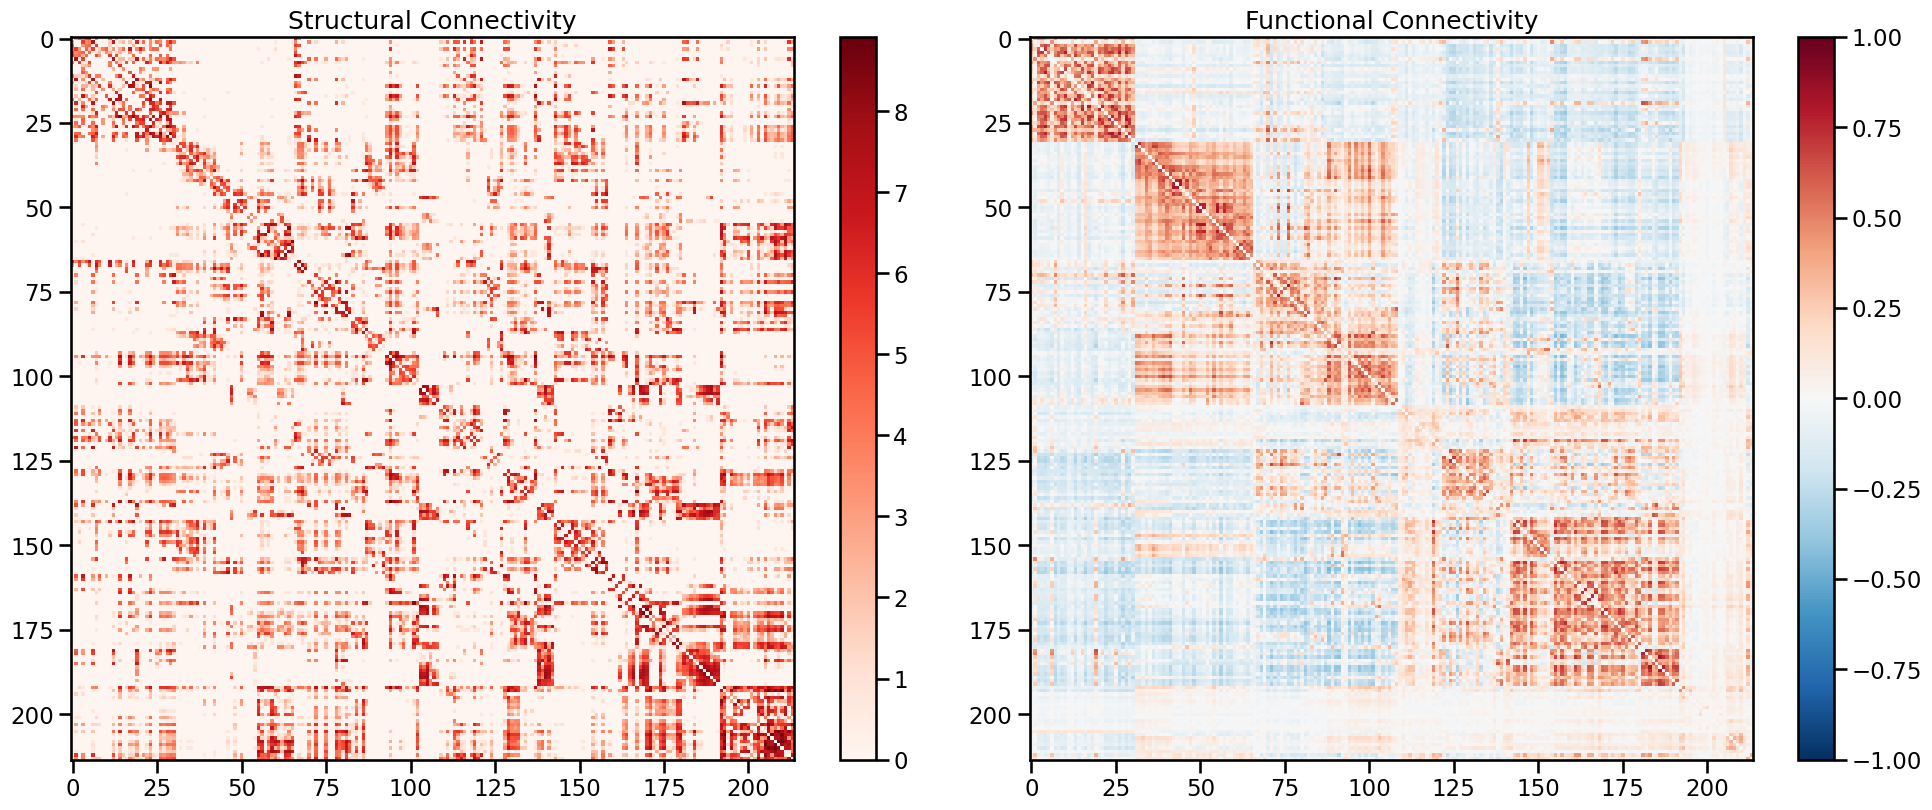

In [39]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(Y_sc, cmap='Reds')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(Y_fc, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Functional Connectivity') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


## Fit PLS model

5
10
15
20


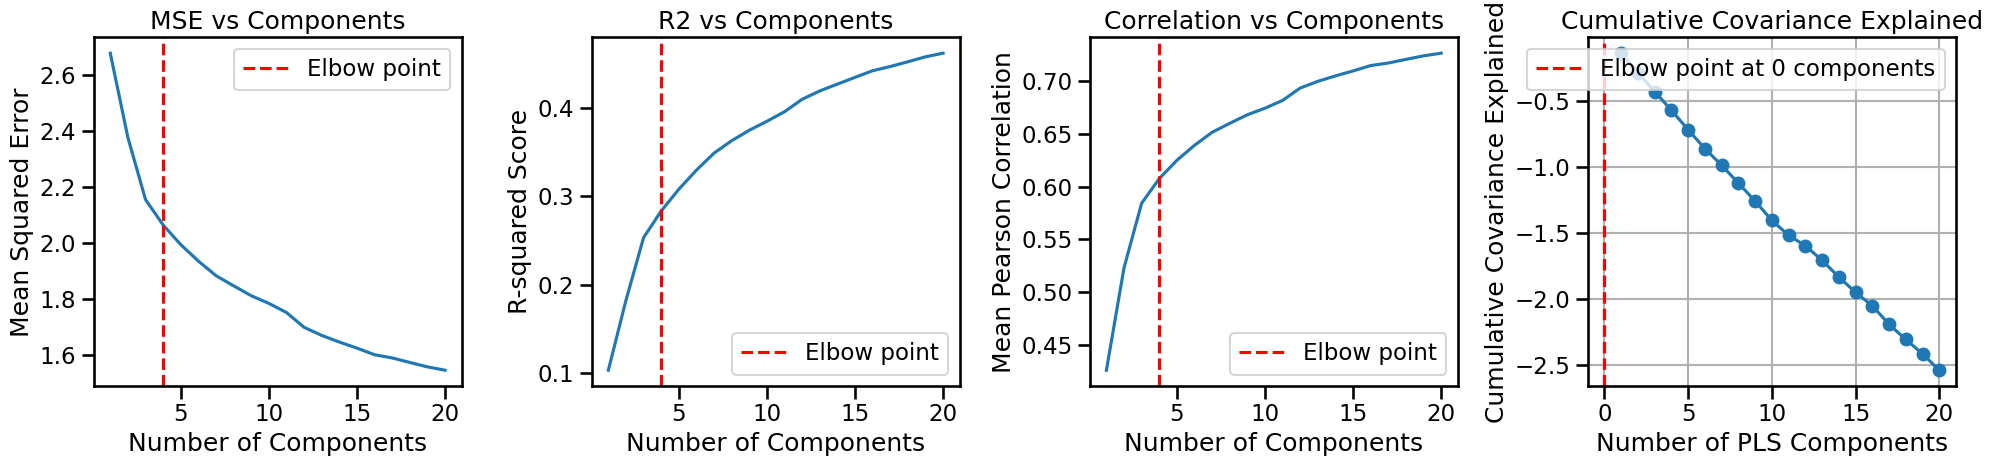

Best model performance (at elbow point):
Number of components: 4
MSE: 2.0645
R2: 0.2832
Mean correlation: 0.6075


In [40]:
def get_best_pls_model(X, Y, max_components=25):
    """
    Evaluate PLS models and return the best one based on correlation score and elbow point.
    
    Args:
        X: Input features array
        Y: Target array
        max_components: Maximum number of components to try
        
    Returns:
        PLSRegression: Best performing PLS model
        dict: Dictionary containing performance metrics
    """
    # Initialize lists to store metrics
    mse_scores = []
    r2_scores = []
    corr_scores = []
    covariance_explained = []
    models = []

    # Scale data for covariance calculation
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    # Compute total covariance between X and Y
    total_covariance = np.sum(np.cov(X_scaled.T, Y_scaled.T, bias=True)[0:len(X_scaled.T), len(X_scaled.T):])

    # Try different numbers of components
    for n_comp in range(1, max_components + 1):
        if n_comp % 5 == 0: 
            print(n_comp)
        
        # Calculate covariance explained
        pls_scaled = PLSRegression(n_components=n_comp)
        pls_scaled.fit(X_scaled, Y_scaled)
        X_scores = pls_scaled.x_scores_
        Y_scores = pls_scaled.y_scores_
        cov_sum = np.sum([np.cov(X_scores[:, i], Y_scores[:, i])[0, 1] for i in range(X_scores.shape[1])])
        covariance_explained.append(cov_sum / total_covariance)

        # refit on unscaled data for predictions in original data space        
        pls = PLSRegression(n_components=n_comp)
        pls.fit(X, Y)
        models.append(pls)
        #models.append(pls_scaled)

        X = X # X_scaled
        Y = Y # Y_scaled
        # Make predictions
        Y_pred = pls.predict(X)
        
        # Calculate metrics
        mse = mean_squared_error(Y, Y_pred)
        r2 = r2_score(Y, Y_pred)
        
        # Calculate Pearson correlation for each connection
        pearson_corr = pearsonr(Y.flatten(), Y_pred.flatten())[0]
        
        # Store metrics
        mse_scores.append(mse)
        r2_scores.append(r2)
        corr_scores.append(pearson_corr)

    # Find elbow point using kneedle algorithm
    x = np.array(range(1, max_components + 1))
    y = np.array(corr_scores)
    
    # Normalize data for knee detection
    x_normalized = (x - min(x)) / (max(x) - min(x))
    y_normalized = (y - min(y)) / (max(y) - min(y))
    
    # Find knee point
    kn = KneeLocator(x_normalized, y_normalized, curve='concave', direction='increasing')
    elbow_idx = int(kn.knee * max_components) - 1  # Convert back to original scale
    
    # Use elbow point as best model
    best_model = models[elbow_idx]
    
    # Store metrics in dictionary
    metrics = {
        'n_components': elbow_idx + 1,
        'mse': mse_scores[elbow_idx],
        'r2': r2_scores[elbow_idx],
        'correlation': corr_scores[elbow_idx]
    }
    
    # Plot metrics
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].plot(range(1, max_components + 1), mse_scores)
    axes[0].axvline(x=elbow_idx + 1, color='r', linestyle='--', label='Elbow point')
    axes[0].set_xlabel('Number of Components')
    axes[0].set_ylabel('Mean Squared Error')
    axes[0].set_title('MSE vs Components')
    axes[0].legend()

    axes[1].plot(range(1, max_components + 1), r2_scores)
    axes[1].axvline(x=elbow_idx + 1, color='r', linestyle='--', label='Elbow point')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('R-squared Score')
    axes[1].set_title('R2 vs Components')
    axes[1].legend()

    axes[2].plot(range(1, max_components + 1), corr_scores)
    axes[2].axvline(x=elbow_idx + 1, color='r', linestyle='--', label='Elbow point')
    axes[2].set_xlabel('Number of Components')
    axes[2].set_ylabel('Mean Pearson Correlation')
    axes[2].set_title('Correlation vs Components')
    axes[2].legend()

    axes[3].plot(range(1, max_components + 1), covariance_explained, marker='o')
    axes[3].set_xlabel('Number of PLS Components')
    axes[3].set_ylabel('Cumulative Covariance Explained')
    axes[3].set_title('Cumulative Covariance Explained')
    
    # Find elbow point in covariance explained curve
    x = np.array(range(1, max_components + 1))
    y = np.array(covariance_explained)
    x_normalized = (x - min(x)) / (max(x) - min(x))
    y_normalized = (y - min(y)) / (max(y) - min(y))
    kn = KneeLocator(x_normalized, y_normalized, curve='concave', direction='increasing')
    covar_elbow_idx = int(kn.knee * max_components)
    axes[3].axvline(x=covar_elbow_idx, color='r', linestyle='--', 
                    label=f'Elbow point at {covar_elbow_idx} components')
    
    # Find where 95% threshold is crossed
    threshold_idx = next((i for i, x in enumerate(covariance_explained) if x >= 0.95), None)
    if threshold_idx is not None:
        axes[3].axvline(x=threshold_idx + 1, color='g', linestyle='--', 
                       label=f'95% reached at {threshold_idx + 1} components')
    
    axes[3].grid(True)
    axes[3].legend()

    plt.tight_layout()
    plt.show()

    print(f"Best model performance (at elbow point):")
    print(f"Number of components: {metrics['n_components']}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"R2: {metrics['r2']:.4f}")
    print(f"Mean correlation: {metrics['correlation']:.4f}")
    
    return best_model, metrics
    
# Get best PLS model
max_components = min(X.shape[1], Y.shape[1]) // 2 # half of max possible components
max_components = 20
best_pls_model, metrics = get_best_pls_model(X, Y, max_components)


In [44]:
# Print dimensionality of PLS parameters
print("PLS Model Parameter Dimensions:")
print("\nWeights:")
print(f"X weights: {best_pls_model.x_weights_.shape} - Left singular vectors of cross-covariance matrices")  
print(f"Y weights: {best_pls_model.y_weights_.shape} - Right singular vectors of cross-covariance matrices")

print("\nLoadings:")
print(f"X loadings: {best_pls_model.x_loadings_.shape} - Loadings/coefficients for X features")
print(f"Y loadings: {best_pls_model.y_loadings_.shape} - Loadings/coefficients for Y targets")

print("\nScores:")
print(f"X scores: {best_pls_model.x_scores_.shape} - Transformed X samples in latent space") 
print(f"Y scores: {best_pls_model.y_scores_.shape} - Transformed Y targets in latent space")

print("\nRotations:")
print(f"X rotations: {best_pls_model.x_rotations_.shape} - Projection matrix for transforming X")
print(f"Y rotations: {best_pls_model.y_rotations_.shape} - Projection matrix for transforming Y")

print("\nCoefficients and Intercepts:")
print(f"Coefficients: {best_pls_model.coef_.shape} - Coefficients for predicting Y from X")
print(f"Intercepts: {best_pls_model.intercept_.shape} - Intercept terms for predictions")


PLS Model Parameter Dimensions:

Weights:
X weights: (105, 4) - Left singular vectors of cross-covariance matrices
Y weights: (214, 4) - Right singular vectors of cross-covariance matrices

Loadings:
X loadings: (105, 4) - Loadings/coefficients for X features
Y loadings: (214, 4) - Loadings/coefficients for Y targets

Scores:
X scores: (214, 4) - Transformed X samples in latent space
Y scores: (214, 4) - Transformed Y targets in latent space

Rotations:
X rotations: (105, 4) - Projection matrix for transforming X
Y rotations: (214, 4) - Projection matrix for transforming Y

Coefficients and Intercepts:
Coefficients: (214, 105) - Coefficients for predicting Y from X
Intercepts: (214,) - Intercept terms for predictions


In [45]:
print(best_pls_model.n_components)

4


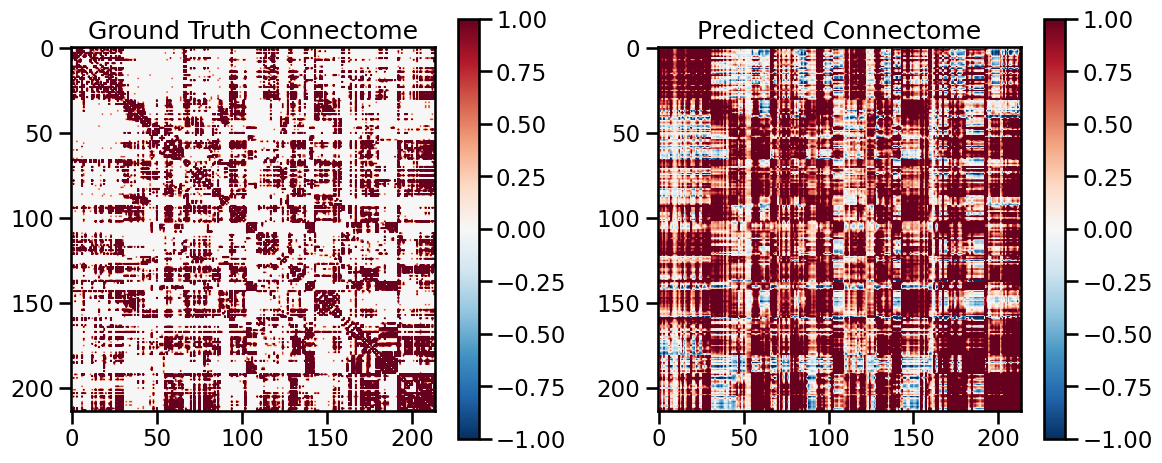

In [46]:
# Get predictions and ground truth
Y_pred = best_pls_model.predict(X)
Y_true = Y

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y_true, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Ground Truth Connectome')
plt.colorbar(im1, ax=ax1)

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Predicted Connectome')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
hemisphere:  left
rotated_ids shape: (214, 1000)
permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


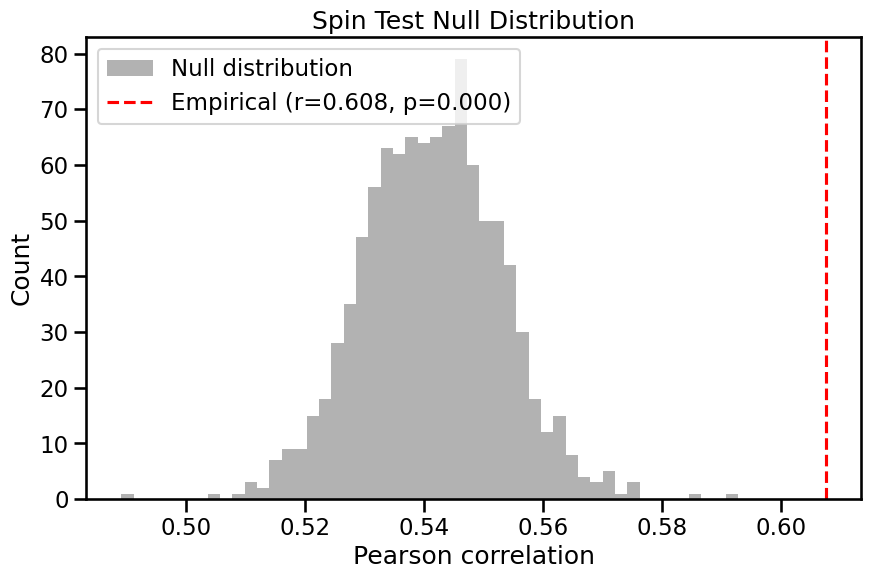

In [48]:
# Spatial null model
'''
- Idea is that autocorrelation in gene expression, X, may drive the PLS solution
- To address this we can generate a spatial permutation of either the gene expression data or the connectome data an refit the PLS model
- Here we will permute the target data as in Hansen, 2021

- The spin test embodies the null hypothesis that genes and connectivity values are spatially correlated with each other because of inherent spatial autocorrelation.
- In Hansen, 2021, the P value is computed as the proportion of null singular values that are greater in magnitude than the empirical singular values.
- Thus, the P value represents the probability that the observed spatial correspondence between genes and connectivity values could occur by randomly correlating maps with comparable spatial autocorrelation

- In our case the null distribution could be the pearson-r values (or other metrics) of the best PLS model as determined by elbow point. 
'''
def run_spin_test(X, Y_true, n_components, left_coords, right_coords, hemisphere, n_perms=1000, shuffle_target=True):
    """
    Run spin test permutation analysis for PLS model
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input transcriptome data
    Y_true : array-like of shape (n_samples, n_samples) 
        Input connectome data
    n_components : int
        Number of PLS components to use
    left_coords : array-like
        Left hemisphere coordinates
    right_coords : array-like  
        Right hemisphere coordinates
    n_perms : int, default=1000
        Number of permutations for null distribution
    shuffle_target : bool, default=True
        If True, shuffle connectome (Y). If False, shuffle transcriptome (X)
        
    Returns:
    --------
    empirical_corr : float
        Empirical correlation
    p_value : float
        P-value from permutation test
    null_corrs : array
        Null distribution correlations
    """
    
    # Refit PLS model with specified number of components
    best_pls_model = PLSRegression(n_components=n_components)
    best_pls_model.fit(X, Y_true)

    # Calculate empirical correlation
    Y_pred_empirical = best_pls_model.predict(X)
    empirical_corr = pearsonr(Y_true.flatten(), Y_pred_empirical.flatten())[0]

    # Generate all rotations beforehand
    rotated_ids = rotate_parcellation(left_coords, right_coords, nrot=n_perms)
    rotated_ids = rotated_ids.astype(int)
    
    print('hemisphere: ', hemisphere)
    if hemisphere == 'left':
        rotated_ids = rotated_ids[:len(left_coords)]
    elif hemisphere == 'right':
        rotated_ids = rotated_ids[len(left_coords):]

    print(f"rotated_ids shape: {rotated_ids.shape}")

    # Initialize array to store null correlations
    null_corrs = np.zeros(n_perms)

    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
        perm_ids = rotated_ids[:, i]
        
        if shuffle_target: # Shuffle connectome
            Y_rotated = Y_true[perm_ids][:, perm_ids]
            X_rotated = X
        else: # Shuffle transcriptome
            Y_rotated = Y_true
            X_rotated = X[perm_ids]
        
        # Fit PLS with same number of components on rotated data
        null_pls = PLSRegression(n_components=n_components)
        null_pls.fit(X_rotated, Y_rotated)
        
        # Get predictions and calculate correlation
        Y_pred_null = null_pls.predict(X_rotated)
        null_corrs[i] = pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = np.mean(null_corrs >= empirical_corr)

    # Plot null distribution
    plt.figure(figsize=(10, 6))
    plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
    plt.axvline(empirical_corr, color='red', linestyle='--', 
                label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    plt.xlabel('Pearson correlation')
    plt.ylabel('Count')
    plt.title('Spin Test Null Distribution')
    plt.legend()
    plt.show()
    
    return empirical_corr, p_value, null_corrs

# Run the spin test
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X, 
    Y_true=Y_true,
    n_components= best_pls_model.n_components, 
    left_coords=left_coords,
    right_coords=right_coords,
    hemisphere='left',
    n_perms=1000,
    shuffle_target=False
)

### Run a train-test split for the flattened PLS model

Number of components for 95% variance PCA: 34
X shape: (114, 10760)
X_pca shape: (114, 34)
Y_sc shape: (114, 114)
Y_sc_spectralL shape: (114, 113)
Y_sc_spectralA shape: (114, 114)
Y_fc shape: (114, 114)
Coordinates shape: (114, 3)
Y shape (114, 114)
feature_name:  transcriptome
processing_type:  None
X shape (114, 10760)


  return LooseVersion(v) >= LooseVersion(check)

ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.



 Test fold num: 1 X_train shape: (7140, 21520) Y_train shape: (7140,) X_test shape: (812, 21520) Y_test shape: (812,)


wandb: Currently logged in as: asratzan (alexander-ratzan-new-york-university). Use `wandb login --relogin` to force relogin


2
3
4
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.012 total time=   1.1s
[CV 2/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.012 total time=   1.2s
[CV 3/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.011 total time=   1.2s
[CV 1/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.011 total time=   1.4s
[CV 2/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.012 total time=   1.4s
[CV 3/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.010 total time=   1.4s
[CV 1/3] END max_iter=1000, n_components=3, scale=True, tol=1e-07;, score=-0.011 total time=   1.7s
[CV 2/3] END max_iter=1000, n_components=3, scale=True, tol=1e-07;, score=-0.012 total time=   1.7s
[CV 3/3] END max_iter=1000, n_components=3, scale=True, tol=1e-07;, score=-0.014 total time=   1.7s
[CV 1/3] END max_iter=1000, n_comp

  matrix[i, j] = vector[vector_index]



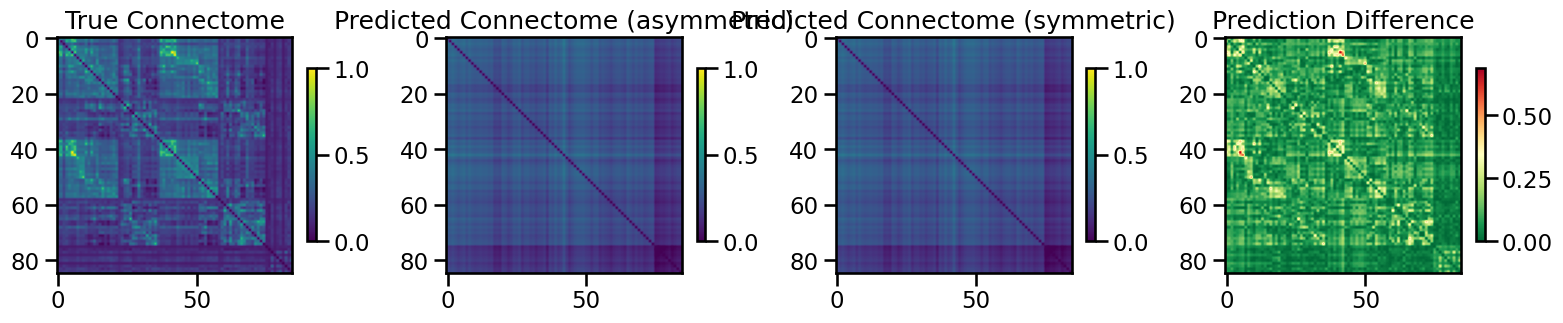

  matrix[i, j] = vector[vector_index]



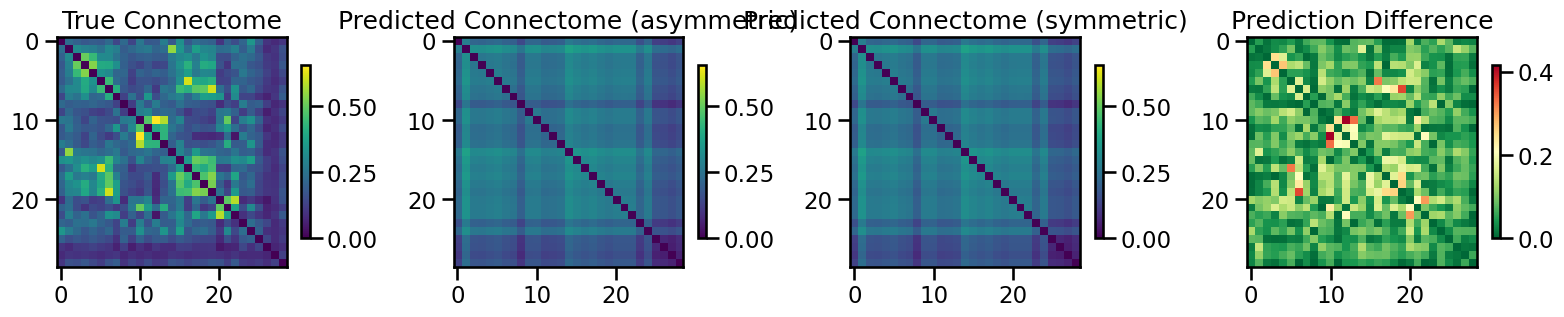

  self.comm = Comm(**args)




TRAIN METRICS: {'mse': 0.011008057215730796, 'mae': 0.07907762311988698, 'r2': 0.27679103887715784, 'pearson_corr': 0.5261093411802891, 'geodesic_distance': 10.013284100598572}
TEST METRICS: {'mse': 0.009533709205847752, 'mae': 0.07611566434193294, 'r2': 0.24912694202541397, 'pearson_corr': 0.5202709311911493, 'geodesic_distance': 7.040357713363625}
BEST VAL SCORE -0.011277797233646086
BEST MODEL PARAMS {'copy': True, 'max_iter': 1000, 'n_components': 2, 'scale': True, 'tol': 1e-07}


  from IPython.core.display import HTML, display  # type: ignore



best_val_loss,▁
best_val_loss,-0.01128


Final evaluation metrics logged successfully.
CPU Usage: 9.7%
RAM Usage: 7.8%
Available RAM: 347.6G
Total RAM: 377.1G
| ID | GPU | MEM |
------------------
|  0 | 10% |  4% |

 Test fold num: 2 X_train shape: (7140, 21520) Y_train shape: (7140,) X_test shape: (812, 21520) Y_test shape: (812,)
1
3
4
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.010 total time=   1.2s
[CV 2/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.012 total time=   1.2s
[CV 3/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.010 total time=   1.2s
[CV 1/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.010 total time=   1.4s
[CV 2/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.012 total time=   1.4s
[CV 3/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.010 total time=   1.5s
[CV 1/3] END max_iter=1000, n_components

  matrix[i, j] = vector[vector_index]



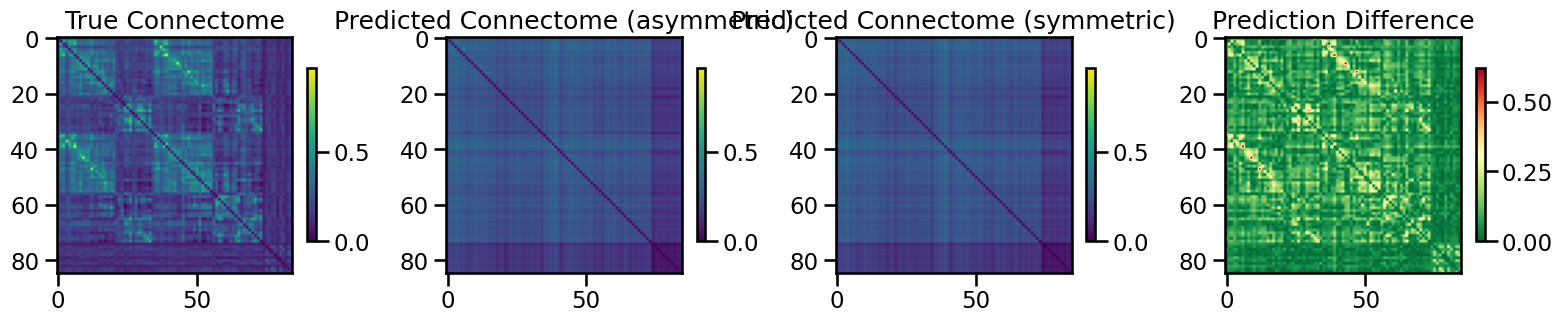

  matrix[i, j] = vector[vector_index]



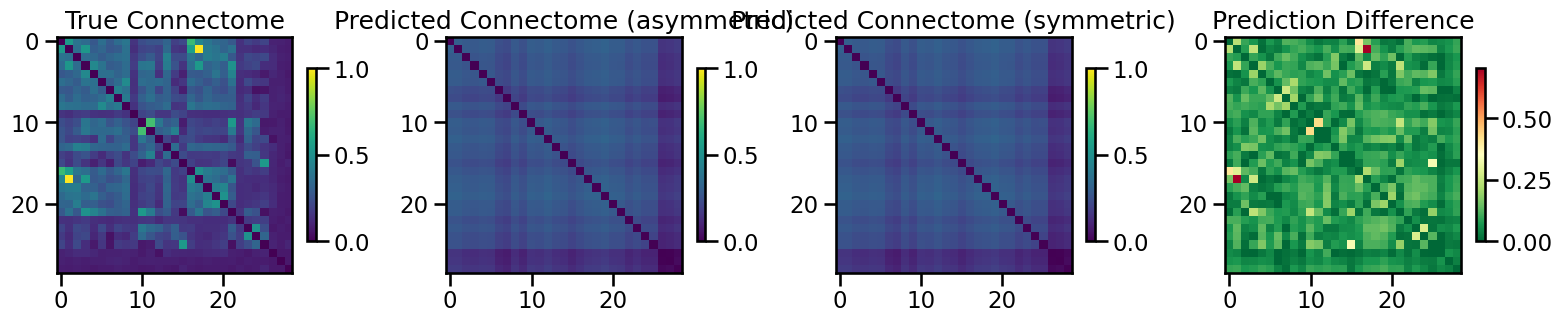

  self.comm = Comm(**args)




TRAIN METRICS: {'mse': 0.010311689336920685, 'mae': 0.07582057563473313, 'r2': 0.24180451041234052, 'pearson_corr': 0.4917362203583753, 'geodesic_distance': 10.214380477212206}
TEST METRICS: {'mse': 0.011002890211222239, 'mae': 0.08123039168244645, 'r2': 0.3254170954476132, 'pearson_corr': 0.5875322742697606, 'geodesic_distance': 5.832159018746019}
BEST VAL SCORE -0.010710051603292381
BEST MODEL PARAMS {'copy': True, 'max_iter': 1000, 'n_components': 2, 'scale': True, 'tol': 1e-07}


  from IPython.core.display import HTML, display  # type: ignore



best_val_loss,▁
best_val_loss,-0.01071


Final evaluation metrics logged successfully.
CPU Usage: 11.5%
RAM Usage: 7.8%
Available RAM: 347.6G
Total RAM: 377.1G
| ID | GPU | MEM |
------------------
|  0 | 60% |  4% |

 Test fold num: 3 X_train shape: (7310, 21520) Y_train shape: (7310,) X_test shape: (756, 21520) Y_test shape: (756,)
1
2
4
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.010 total time=   1.2s
[CV 2/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.012 total time=   1.2s
[CV 3/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.011 total time=   1.2s
[CV 1/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.010 total time=   1.5s
[CV 2/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.011 total time=   1.5s
[CV 3/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.010 total time=   1.5s
[CV 1/3] END max_iter=1000, n_component

  matrix[i, j] = vector[vector_index]



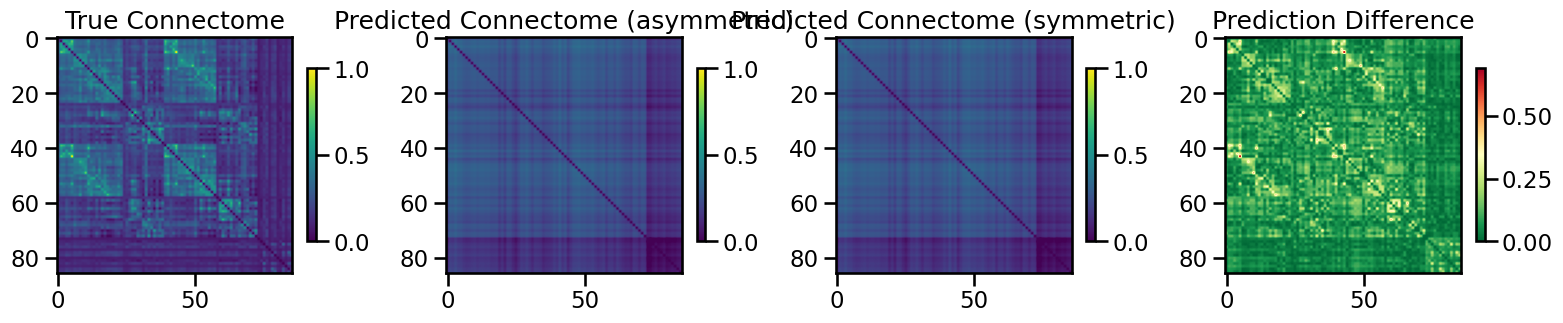

  matrix[i, j] = vector[vector_index]



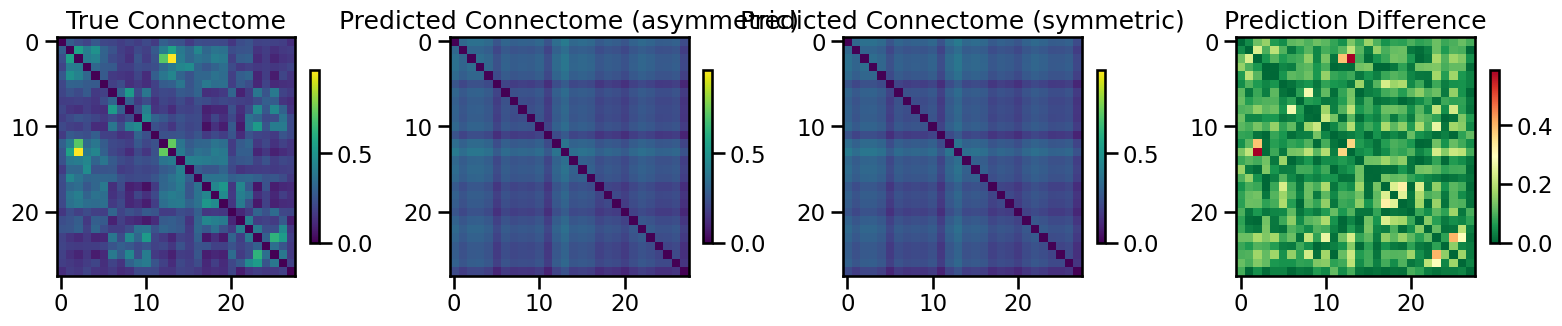

  self.comm = Comm(**args)




TRAIN METRICS: {'mse': 0.009736280342964896, 'mae': 0.07444734130067122, 'r2': 0.32326831285777513, 'pearson_corr': 0.5685668939164283, 'geodesic_distance': 10.69321284404721}
TEST METRICS: {'mse': 0.012112123064340743, 'mae': 0.08451050664608295, 'r2': 0.06948662019920981, 'pearson_corr': 0.3084396972545264, 'geodesic_distance': 4.375004972785306}
BEST VAL SCORE -0.01035151771274499
BEST MODEL PARAMS {'copy': True, 'max_iter': 1000, 'n_components': 2, 'scale': True, 'tol': 1e-07}


  from IPython.core.display import HTML, display  # type: ignore



best_val_loss,▁
best_val_loss,-0.01035


Final evaluation metrics logged successfully.
CPU Usage: 11.6%
RAM Usage: 7.8%
Available RAM: 347.6G
Total RAM: 377.1G
| ID | GPU | MEM |
------------------
|  0 | 54% |  4% |

 Test fold num: 4 X_train shape: (7310, 21520) Y_train shape: (7310,) X_test shape: (756, 21520) Y_test shape: (756,)
1
2
3
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.009 total time=   1.2s
[CV 2/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.012 total time=   1.2s
[CV 3/3] END max_iter=1000, n_components=1, scale=True, tol=1e-07;, score=-0.012 total time=   1.2s
[CV 1/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.010 total time=   1.4s
[CV 2/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.011 total time=   1.5s
[CV 3/3] END max_iter=1000, n_components=2, scale=True, tol=1e-07;, score=-0.012 total time=   1.5s
[CV 1/3] END max_iter=1000, n_component

  matrix[i, j] = vector[vector_index]



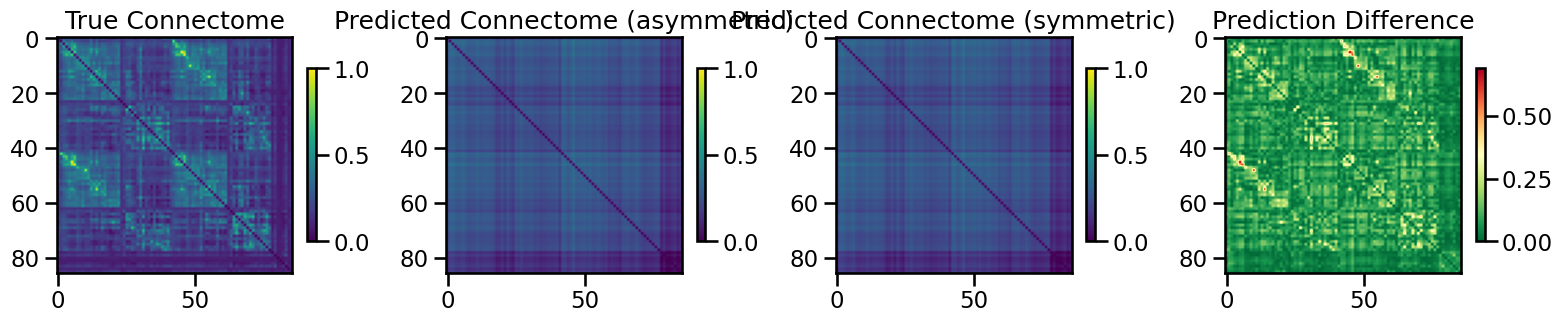

  matrix[i, j] = vector[vector_index]



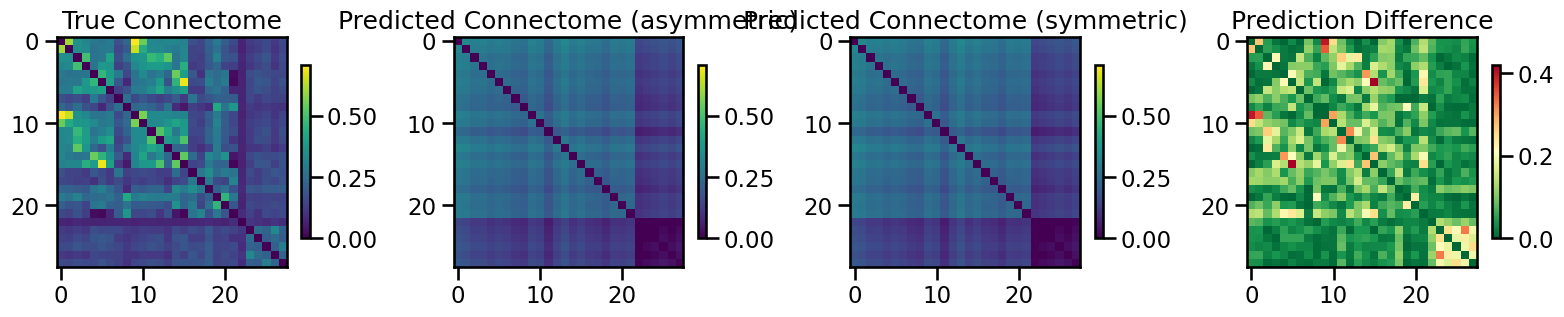

  self.comm = Comm(**args)




TRAIN METRICS: {'mse': 0.010863356687223253, 'mae': 0.0789168909158036, 'r2': 0.26325897302226997, 'pearson_corr': 0.5130876855102546, 'geodesic_distance': 9.890284606733116}
TEST METRICS: {'mse': 0.010424018173175327, 'mae': 0.07339100201172448, 'r2': 0.20754717568101788, 'pearson_corr': 0.507797243768241, 'geodesic_distance': 7.541694363771262}
BEST VAL SCORE -0.010913188766778962
BEST MODEL PARAMS {'copy': True, 'max_iter': 1000, 'n_components': 2, 'scale': True, 'tol': 1e-07}


  from IPython.core.display import HTML, display  # type: ignore



best_val_loss,▁
best_val_loss,-0.01091


Final evaluation metrics logged successfully.
CPU Usage: 11.2%
RAM Usage: 7.8%
Available RAM: 347.6G
Total RAM: 377.1G
| ID | GPU | MEM |
------------------
|  0 |  7% |  4% |


88735

In [19]:
# Run simulation
single_sim_run(
              cv_type='random',
              random_seed=42,
              model_type='pls',
              feature_type=[{'transcriptome': None}],
              connectome_target='FC',
              use_gpu=False,
              use_shared_regions=False,
              test_shared_regions=False,
              omit_subcortical=False,
              parcellation='S100',
              gene_list='0.2',
              hemisphere='both',
              search_method=('grid', 'mse', 10),
              save_sim=False,
              track_wandb=True,
              skip_cv=False
              )

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Clear CPU memory
import gc
gc.collect()